# Aprendizaje Supervisado I
# UdeSA, 2023
## Profesores: Marcela Svarc, Juan Manuel Pérez
### Alumno: Santiago Lares Harbin

## Taller 1: Algoritmos de clasificación + evaluación


**Fecha de entrega: 06/10/2023, 23:59 hs**

Enviar individualmente a perezj@udesa.edu.ar con subject <TALLER-SUPERVISADO><APELLIDO>



Este notebook contiene los ejercicios del taller 1. Los mismos deberán ser realizados usando Python. Pueden hacerlo en colab como en sus propias computadoras.



In [270]:
import sklearn
from sklearn.metrics import accuracy_score
import numpy as np
import scipy
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# 1. Métricas

### 1.1 Programar las siguientes métricas como funciones de python con la siguiente aridad:


```python
def metrica(y_true,y_pred):
  ...
  return score
```



1.   accuracy
2.   precision
3.   recall
4.   F1-score
5.   F $_{\beta}$-score
6.   Matriz de confusión


In [305]:
def accuracy(y_true, y_pred):
    x=(y_true==y_pred)
    return x.mean()

def precision(y_true, y_pred):
    tp=(y_true==y_pred) & (y_pred==1)
    tp=tp.sum()
    fp=(y_true==0) & (y_pred==1)
    fp=fp.sum()
    if tp + fp == 0:
        return 0
    pr=tp/(tp+fp)
    return pr

def recall(y_true, y_pred):
    tp=(y_true==y_pred) & (y_pred==1)
    tp=tp.sum()
    fn=(y_true==1) & (y_pred==0)
    fn=fn.sum()
    if tp + fn == 0:
        return 0
    rc=tp/(tp+fn)
    return rc

def f1(y_true, y_pred):
    nominador=precision(y_true, y_pred)*recall(y_true, y_pred)
    denominador=precision(y_true, y_pred)+recall(y_true, y_pred)
    ef1=(2*nominador)/denominador
    return ef1

def confusion_matrix(y_true, y_pred):
    tp = (y_true == y_pred) & (y_pred == 1)
    tp = tp.sum()
    fp = (y_true == 0) & (y_pred == 1)
    fp = fp.sum()
    fn = (y_true == 1) & (y_pred == 0)
    fn = fn.sum()
    tn = (y_true == y_pred) & (y_pred == 0)
    tn = tn.sum()
    matrix = np.array([[tn, fp], [fn, tp]])  
    return matrix

### 1.2 Crear diversos casos de test que prueben diferentes aspectos de cada metrica

In [272]:
#Crear tests usando asserts

y_true = np.array([1, 1, 0, 1, 0, 0, 1, 0, 0, 0])
y_pred = np.array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0])

assert np.isclose(accuracy(y_true, y_pred), 7/10)

## Clasificadores

Vamos a implementar los clasificadores usando el mismo esquema de la librería `sklearn`. Para ello, vamos a crear una clase `Clasificador` que tenga los siguientes métodos:

*   `fit(X,y)`: recibe los datos de entrenamiento y los labels y entrena el clasificador
*   `predict(X)`: recibe los datos de test y devuelve las predicciones

Empecemos con clasificadores baseline, es decir, clasificadores que no aprenden nada o casi nada de los datos

### 1.3 Random

Implementar un clasificador que prediga una clase al azar. Para ello, usar la función `np.random.randint`

In [273]:
class RandomClassifier:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.unique_labels = None

    def fit(self, X, y):
        #compruebo que las regresandas sean enteros, sino, modifico
        if y.dtype == 'object':
            self.unique_labels, integer_labels = np.unique(y, return_inverse=True)
            y = integer_labels
        else:
            self.unique_labels = np.unique(y)
            y = y

    def predict(self, X):
        n=X.shape[0]        
        integer_predictions =np.random.randint(low=0,high=self.num_classes, size=n)
        original_predictions = self.unique_labels[integer_predictions]
        return original_predictions

In [274]:
# Genero 1000 etiquetas con 0 y 1000 etiquetas con 1
# Un clasificador aleatorio debería tener un accuracy cercano a 0.5
X = np.random.randint(0, 2, size=(2000, 2))
y_true = np.concatenate([np.zeros(1000), np.ones(1000)])

clf = RandomClassifier(num_classes=2)

clf.fit(X, y_true)

y_pred = clf.predict(X)
assert np.isclose(accuracy_score(y_true, y_pred), 0.5, atol=0.05)

## 1.4 Majority Class Classifier

Programar un algoritmo que prediga la clase mayoritaria sobre los datos



Mirar la documentación de `np.bincount` y `np.argmax`. ¿Para qué sirven?

In [275]:
y = np.array([1,0,0,2,2,2,3,3,4,4,4,4,4,4,4,4])
c=np.bincount(y)
c, np.argmax(c)

(array([2, 1, 3, 2, 8], dtype=int64), 4)

In [276]:
# el majority classifier es una combinacion de bincount y argmax
class MajorityClassifier:
    def __init__(self):
        self.majority = None
        self.classes = None

    def fit(self, y):
        #compruebo que las regresandas sean enteros, sino, modifico
        if y.dtype == 'object':
            self.classes, integer_classes = np.unique(y, return_inverse=True)
            y = integer_classes
        else:
            self.classes = np.unique(y)
            y = y
        c = np.bincount(y)
        self.mc = np.argmax(c)
        return self


    def predict(self, X):
        integer_predictions = np.full(X.shape[0], self.mc)
        
        original_predictions = self.classes[integer_predictions]
        
        return original_predictions


In [277]:
y=np.array([1,2,2,3,4])
X=np.array([0,0,0,1,1])
clf=MajorityClassifier()
clf.fit(X)
clf.predict(X)

array([0, 0, 0, 0, 0])

## 2. Naive Bayes

Supongamos que tenemos un problema de clasificación con $K$ clases, y $p$ predictores/features.

Recordemos que por el teorema de Bayes, podemos escribir la probabilidad de que una instancia $x$ pertenezca a una clase $k$ (posterior) como:

$$P(y=k|x) = \frac{P(x|y=k)P(y=k)}{P(x)}$$

- $P(x|y=k)$ es la probabilidad condicional de $x$ dado que la clase es $k$. Podemos escribirla como $f_k(x)$, donde $f_k$ es la función de densidad de probabilidad de la clase $k$.
- $P(y=k)$ lo podemos modelar como la frecuencia de la clase $k$ en el conjunto de entrenamiento (usualmente, escrita como $\pi_k$)
- $P(x)$ es la probabilidad marginal de $x$, que podemos calcular como la suma de las probabilidades condicionales de $x$ para cada clase $k$ (Probabilidad total)
$$P(x) = \sum_{k=1}^K P(x|y=k)P(y=k)$$

Reescribiendo todo esto, podemos calcular la probabilidad de que una instancia $x$ pertenezca a una clase $k$ como:

$$P(y=k|x) = \frac{f_k(x)\pi_k}{\sum_{j=1}^K f_j(x)\pi_j}$$

$x$ es un vector de $p$ dimensiones, y cada una de sus componentes es una variable aleatoria. Si asumimos que cada componente de $x$ es independiente de las demás, podemos escribir la función de densidad de probabilidad de la clase $k$ como:

$$f_k(x) = \prod_{j=1}^p f_{kj}(x_j)$$

Entonces, para cada clase $k$, tenemos que estimar $p$ funciones de densidad de probabilidad $f_{kj}(x_j)$, una para cada predictor $j$ (tenemos $K \times p$ predictores).

## 2.1 Precalentamiento

### 2.1.2 Estimar funcion de densidad para variables categóricas

Sea $X$ un vector de observaciones de una variable Bernoulli. Utilizar `np.bincount` para estimar la función de densidad de probabilidad de $X$.

In [278]:
X = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
def f_ber(X):
    c=np.bincount(X)
    l=X.shape[0]
    p=c[1]/l
    return(p)

f_ber(X)

0.6

Utilizar `scipy.stats.rv_discrete` para estimar la función de densidad de probabilidad de $X$

La función recibe un parámetro `values` que toma un par de arrays `(Xk, pk)` donde `Xk` son los valores que toma la variable aleatoria y `pk` son las probabilidades asociadas a cada valor.

Utilizar la función `.pmf` para evaluar la función de densidad de probabilidad en un punto.

In [279]:
def f(X):
    p = np.bincount(X) / X.shape[0]
    v = np.unique(X)
    f = scipy.stats.rv_discrete(values=(v, p))
    return(f)

x=f(X)
x.pmf(0), x.pmf(1), x.pmf(2)

(0.4, 0.6, 0.0)

### 3.1 Programar naive bayes para variables categoricas


In [280]:
class NaiveBayes:
    """
    Naive bayes para variables categóricas
    """
    def __init__(self):
        self.priors = None
        self.densities = None
        self.classes = None
    

    def fit(self, X, y):
        #compruebo que las regresandas sean enteros, sino, modifico
        if y.dtype == 'object':
            unique_labels, integer_labels = np.unique(y, return_inverse=True)
            y=integer_labels
        else:
            y=y

        assert X.dtype == int, "X debe ser int"
        assert y.dtype == int, "y debe ser int"
        assert X.shape[0]==y.shape[0], "X debe ser del mismo largo que y"

        self.priors = np.bincount(y) / len(y)
        self.classes = np.unique(y)
        self.features=np.unique(X[0][0])

        n_classes = len(self.classes)
        num_features = X.shape[1]

        # Armo una matriz de n_classes x num_features que sería la cantidad de f_ij que necesito
        self.densities = [[None] * num_features for i in range(n_classes)]
        
        #tengo i por j funciones de densidad
        #num_features es j
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            for j in range(X_c.shape[1]):  # Loop a traves de cada feature X_c_j
                feature_values = X_c[:, j]
                p_x = np.bincount(feature_values) / feature_values.shape[0]
                v_x = np.unique(X_c)
                self.densities[i][j] = scipy.stats.rv_discrete(values=(v_x, p_x))   


    def predict(self, X):
        assert self.priors is not None, "Hay que llamar a fit primero"
        
        predictions = []
        
        for x in X:  # Loop para cada muestra en X
            p_i_x = np.zeros(len(self.classes))  # Inicializar las probabilidades a posteriori como ceros

            for i, c in enumerate(self.classes):  # Loop para cada clase
                p_i = self.priors[i]  # Probabilidad a priori de la clase
                p_i_j = np.ones(len(x))  # Inicializar probabilidades condicionales como unos
                
                for j, feature in enumerate(x):  # Loop para cada característica
                    p_i_j[j] = self.densities[i][j].pmf(feature)  # Actualizar probabilidad condicional
                
                p_i *= np.prod(p_i_j)  # Multiplicar por todas las probabilidades condicionales
                p_i_x[i] = p_i  # Almacenar la probabilidad a posteriori para la clase
                
            predicted_class = np.argmax(p_i_x)  # Elegir la clase con la mayor probabilidad a posteriori
            predictions.append(self.classes[predicted_class])
            
        return np.array(predictions)



Vamos a probar todo esto en un dataset generado aleatoriamente. Este dataset consta de 200 observaciones con 5 variables Bernoulli $X_1, X_2, X_3, X_4, X_5$

$$Y|X_1, X_2, X_3, X_4, X_5 \sim Bernoulli(\frac{X_1 + \ldots + X_5}{5})$$

In [281]:

n_samples = 200
num_vars = 5

np.random.seed(2023)

X = np.random.randint(0, 2, (n_samples, num_vars))

# Creamos  Bernoulli(P/num_vars)

P = X.sum(axis=1) / num_vars
y = np.random.binomial(1, P)

# Train / test split

X_train, y_train = X[:160], y[:160]
X_test, y_test = X[160:], y[160:]

Entrenar el modelo sobre los datos de entrenamiento y predecir sobre los datos de test para:

- RandomClassifier
- MajorityClassifier
- NaiveBayes

Reportar accuracy, precision, recall y F1-score para cada clasificador



- ¿Anda mejor Naive Bayes que los clasificadores baseline? ¿se cumplen las hipótesis de Naive Bayes en este caso?

- **OPCIONAL**. Calcular el error de Bayes. ¿Cómo se compara con el de Naive Bayes?

In [282]:
p_x = np.bincount(X_train[:,3])
p_x 

array([65, 95], dtype=int64)

In [283]:
clf=NaiveBayes()

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

accuracy_nb=accuracy(y_test,y_pred)
precision_nb=precision(y_test,y_pred)
recall_nb=recall(y_test,y_pred)

accuracy_nb, precision_nb, recall_nb

(0.725, 0.8571428571428571, 0.6923076923076923)

In [284]:
clf = RandomClassifier(2)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

accuracy_rnd=accuracy(y_test,y_pred)
precision_rnd=precision(y_test,y_pred)
recall_rnd=recall(y_test,y_pred)

accuracy_rnd, precision_rnd, recall_rnd

(0.6, 0.7272727272727273, 0.6153846153846154)

In [285]:
clf = MajorityClassifier()


clf.fit(y_train)
print("Majority Class:", clf.mc)

y_pred=clf.predict(X_test)

accuracy_mjr=accuracy(y_test,y_pred)
precision_mjr=precision(y_test,y_pred)
recall_mjr=recall(y_test,y_pred)

accuracy_mjr, precision_mjr, recall_mjr


Majority Class: 0


(0.35, 0, 0.0)

### 3.2 Programar naive bayes para variables gaussianas.
¿Cómo podria estimar $P(a_i|v_j)$? Piense en fitear diferentes distribuciones que le permitan luego inferir valores nuevos.

Ayuda: Puede usera `scipy.stats.norm( mu , std ).pdf( new_val )` como funcion de densidad de probabilidad de una normal y evaluarla en new_val




In [286]:
class GaussianNaiveBayes:
    """
    Naive bayes para variables gaussianas
    """
    def __init__(self):
        self.priors = None
        self.densities = None
        self.classes = None
        self.unique_labels= None

    def fit(self, X, y):
        if y.dtype == 'object':
            #compruebo que las regresandas sean enteros, sino, modifico
            self.unique_labels, integer_labels = np.unique(y, return_inverse=True)
            y = integer_labels
        else:
            self.unique_labels = np.unique(y)  # Si y ya es entero, simplemente toma las etiquetas únicas
            y = y

        assert y.dtype == "int64", "y debe ser int"
        assert X.shape[0]==y.shape[0], "X debe ser del mismo largo que y"

        self.priors = np.bincount(y) / len(y)
        self.classes = np.unique(y)
        self.features=np.unique(X[0][0])
        n_classes = len(self.classes)
        num_features = X.shape[1]

        # Armo una matriz de n_classes x num_features que sería la cantidad de f_ij que necesito
        self.densities = [[None] * num_features for i in range(n_classes)]
        
        #tengo i por j funciones de densidad
        #num_features es j
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            for j in range(X_c.shape[1]):  # Loop a traves de cada feature X_c_j
                feature_values = X_c[:, j]
                mu_x=feature_values.mean()
                std_x=feature_values.std()
                v_x = np.unique(X_c)
                self.densities[i][j] = scipy.stats.norm(mu_x, std_x )  # Cambio las funciones de densidad asumiendo variables continuas normales

    def predict(self, X):
        assert self.priors is not None, "Hay que llamar a fit primero"
        
        predictions = []
        
        for x in X:  # Loop para cada muestra en X
            p_i_x = np.zeros(len(self.classes))  # Inicializar las probabilidades a posteriori como ceros

            for i, c in enumerate(self.classes):  # Loop para cada clase
                p_i = self.priors[i]  # Probabilidad a priori de la clase
                p_i_j = np.ones(len(x))  # Inicializar probabilidades condicionales como unos
                
                for j, feature in enumerate(x):  # Loop para cada característica
                    p_i_j[j] = self.densities[i][j].pdf(feature)  # Actualizar probabilidad condicional
                
                p_i *= np.prod(p_i_j)  # Multiplicar por todas las probabilidades condicionales
                p_i_x[i] = p_i  # Almacenar la probabilidad a posteriori para la clase
                
            predicted_class = np.argmax(p_i_x)  # Elegir la clase con la mayor probabilidad a posteriori
            predictions.append(self.classes[predicted_class])
            original_predictions = self.unique_labels[predictions]
            
        return np.array(original_predictions)


### 3.3 LDA

Programar LDA para variables gaussianas

Utilizar las funciones `np.mean` y `np.cov` para estimar los parámetros de las gaussianas

In [287]:
import numpy as np

class LDAClassifier:
    def __init__(self):
        self.means = None
        self.cov_matrix = None
        self.priors = None
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)        
        self.means = {}
        covs = []
        
        self.priors = {}
        
        for c in self.classes:
            X_c = X[y == c]
            
            self.means[c] = np.mean(X_c, axis=0)
            covs.append(np.cov(X_c, rowvar=False))
            
            self.priors[c] = len(X_c) / len(X)
        
        self.cov_matrix = np.mean(covs, axis=0)
        
        self.inv_cov_matrix = np.linalg.inv(self.cov_matrix)

    def predict(self, X):
        preds = []
        for x in X:
            scores = []
            for c in self.classes:
                mean_diff = x - self.means[c]
                score = mean_diff.T @ self.inv_cov_matrix @ mean_diff
                score = -0.5 * score + np.log(self.priors[c])
                scores.append(score)
            
            preds.append(self.classes[np.argmax(scores)])
        
        return np.array(preds)


#### Opcional: Implementar QDA

Leer en el ISLP el capítulo de QDA y programar el algoritmo

In [288]:
import numpy as np

class QDAClassifier:
    def __init__(self):
        self.distributions = {}
        self.priors = {}
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        
        for c in self.classes:
            subset = X[y == c]
            mean_vector = np.mean(subset, axis=0)
            cov_matrix = np.cov(subset, rowvar=False)
            self.distributions[c] = {'mean': mean_vector, 'cov': cov_matrix}
            self.priors[c] = len(subset) / len(X)

    def predict(self, X):
        predictions = []
        
        for x in X:
            posterior_probs = {}
            
            for c in self.classes:
                mean_vector = self.distributions[c]['mean']
                cov_matrix = self.distributions[c]['cov']
                
                diff = x - mean_vector
                
                exponent = -0.5 * diff.T @ np.linalg.inv(cov_matrix) @ diff
                coefficient = 1 / np.sqrt((2 * np.pi)**len(x) * np.linalg.det(cov_matrix))
                
                posterior_probs[c] = coefficient * np.exp(exponent) * self.priors[c]
            
            predicted_class = max(posterior_probs, key=posterior_probs.get)
            predictions.append(predicted_class)
        
        return np.array(predictions)

## 3.4 Dataset Iris (Lirios)


![texto alternativo](https://cdn0.ecologiaverde.com/es/posts/4/1/0/tipos_de_lirios_3014_orig.jpg)

El dataset Iris es un dataset clásico de clasificación. Contiene 150 observaciones de 3 clases de flores distintas (50 observaciones por clase). Cada observación tiene 4 features: largo y ancho del sépalo y largo y ancho del pétalo.

Fue introducido por el estadístico y biólogo británico Ronald Fisher en 1936.

Dato importante: si tienen gatos, no tengan lirios cerca. Son sumamente tóxicos.

In [289]:
from sklearn import datasets
import pandas as pd

iris = datasets.load_iris()
X = iris.data
y = iris.target

df = pd.DataFrame(X, columns=[x.strip(" (cm)") for x in iris.feature_names])
df["species"] = [iris.target_names[x] for x in y]
df

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


### 3.4.1 Análisis exploratorio

Explorar el dataset. ¿Qué tipo de problema es? ¿Qué tipo de features tiene?

Use `sns.displot` y `sns.pairplot` para visualizar las distribuciones de las variables y las relaciones entre ellas.

¿Qué clase es más fácil de separar de las otras dos? ¿Cuál es más difícil?

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [291]:
df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


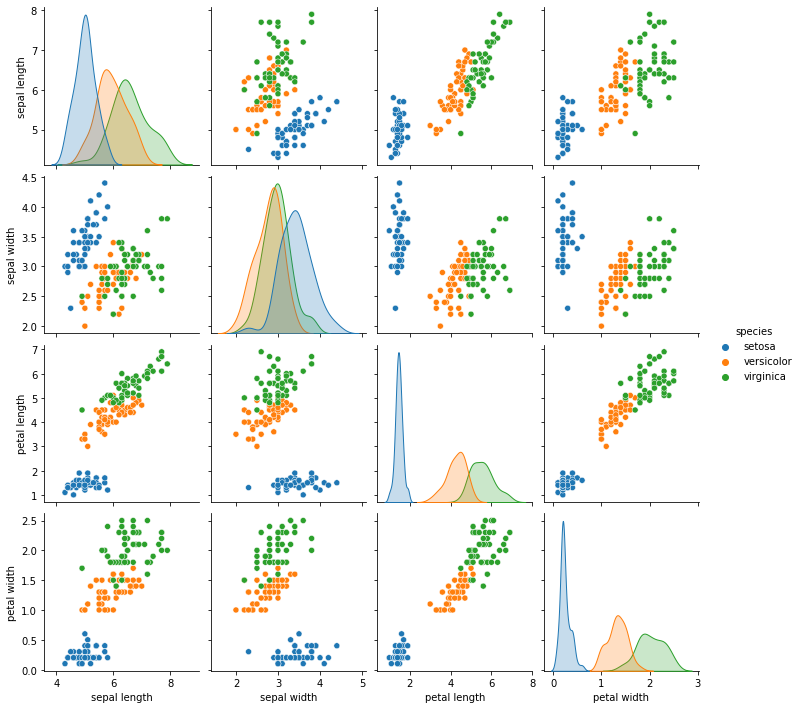

In [292]:
sns.pairplot(data=df, hue= "species")

##### La clase "setosa" pareceria ser mas facil de separar, las otras dos se superponen en algunas variables.

### 3.4.2 Split train/test

Utilice la función `train_test_split` de `sklearn.model_selection` para dividir los datos en train y test. Utilice un 66% para train y un 33% para test.

Setee como `random_state` el número 42 (¿para qué sirve?). Usar `stratify` para que los datos se dividan de manera estratificada (¿qué es esto?)


Consultar [la documentación de `train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) para ver cómo se usa

In [297]:
from sklearn.model_selection import train_test_split
X=df.drop("species",axis=1)
y=df["species"]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.66,test_size=0.33,
random_state=42, stratify=y)
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

### 3.4.3 Entrenamiento de modelos

Entrenar los modelos que ya programamos y predecir sobre los datos de test. Reportar accuracy, precision, recall y F1-score para cada clasificador (pueden usar `sklearn.metrics.classification_report`)

In [298]:
# Inicializa los modelos
r_clas = RandomClassifier(len(np.unique(y_test)))
m_clas = MajorityClassifier()
gn_bayes = GaussianNaiveBayes()

# Entrena los modelos y guarda las predicciones
models = {'RandomClassifier': r_clas, 'MajorityClassifier': m_clas, 'GaussianNaiveBayes': gn_bayes}
predictions = {}

for name, model in models.items():
    if name == 'MajorityClassifier':
        model.fit(y_train)
    else:
        model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

# Obtiene los nombres de las clases (etiquetas únicas en y_test)
unique_labels = np.unique(y_test)

# Genera classification_reports y convierte a DataFrames
reports = {}
for name, y_pred in predictions.items():
    report_dict = sklearn.metrics.classification_report(y_test, y_pred, output_dict=True, target_names=unique_labels.astype(str))
    reports[name] = pd.DataFrame(report_dict).transpose()

# Concatena todos los DataFrames
final_report = pd.concat(reports, names=['Model', 'Metrics'])

# Muestra el reporte final
print(final_report)

                                 precision    recall  f1-score  support
Model              Metrics                                             
RandomClassifier   setosa         0.380952  0.470588  0.421053    17.00
                   versicolor     0.384615  0.294118  0.333333    17.00
                   virginica      0.437500  0.437500  0.437500    16.00
                   accuracy       0.400000  0.400000  0.400000     0.40
                   macro avg      0.401023  0.400735  0.397295    50.00
                   weighted avg   0.400293  0.400000  0.396491    50.00
MajorityClassifier setosa         0.340000  1.000000  0.507463    17.00
                   versicolor     0.000000  0.000000  0.000000    17.00
                   virginica      0.000000  0.000000  0.000000    16.00
                   accuracy       0.340000  0.340000  0.340000     0.34
                   macro avg      0.113333  0.333333  0.169154    50.00
                   weighted avg   0.115600  0.340000  0.172537  

## 3.4.4 Análisis de errores

Calcular la matriz de confusión para el mejor clasificador. ¿Qué clase se confunde más con qué clase? ¿Por qué?

Usar `sklearn.metrics.confusion_matrix`

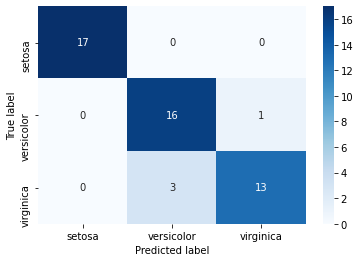

In [304]:
from sklearn.metrics import confusion_matrix
# Usamos el modelo que tenga el mejor rendimiento según alguna métrica (precisión, F1, etc.)
y_pred = gn_bayes.predict(X_test)

# Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualiza la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Las clases que mas se suelen confundir para GaussianNaiveBayes es "virginica" con "versicolor".